# NATRE vs CTD-χpod

I'm pretty sure that the CTd-χpod data needs more cleanup, but there are some interesting sampling questions explored in this notebook.

1. What happens if I just use single latitude or single longitude lines from the original NATRE dataset?
2. How do  number of obs compare?

In [5]:
%load_ext watermark
%matplotlib inline

import glob

import cf_xarray as cfxr
import dask
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm
import xarray as xr
import xgcm
from IPython.display import Image
from xarray.tests import raise_if_dask_computes

%aimport eddydiff
ed = eddydiff

xr.set_options(keep_attrs=True)

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 200
plt.style.use("ggplot")


%watermark -iv
xr.DataArray([1.0])

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
matplotlib : 3.5.1
eddydiff   : 0.1
xgcm       : 0.6.0
dcpy       : 0.1
distributed: 2021.12.0
scipy      : 1.7.3
tqdm       : 4.62.3
cf_xarray  : 0.6.3.dev22+gaba4dbb.d20220112
numpy      : 1.22.0
dask       : 2021.12.0
xarray     : 0.10.3+dev29.ga8e0be8d1



<xarray.DataArray (dim_0: 1)>
array([1.])
Dimensions without coordinates: dim_0

In [2]:
if "client" in locals():
    client.cluster.close()
    client.close()
client = distributed.Client(n_workers=6, threads_per_worker=1)
client

/Users/dcherian/mambaforge/envs/eddydiff/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58120 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:58120/status,
Dashboard: http://127.0.0.1:58120/status,Workers: 6
Total threads: 6,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58121,Workers: 6
Dashboard: http://127.0.0.1:58120/status,Total threads: 6
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:58140,Total threads: 1
Dashboard: http://127.0.0.1:58141/status,Memory: 2.67 GiB
Nanny: tcp://127.0.0.1:58125,


In [ ]:
natre = ed.natre.read_natre().load().drop("depth")
bins = ed.sections.choose_bins(natre.gamma_n, depth_range=np.arange(150, 2001, 100))

In [129]:
a05 = xr.load_dataset("../datasets/ctd-A05-density-binned.nc").query({"gamma_n": "pres < 2000"})

## Are there any obvious sampling biases in NATRE? 

No.

In [106]:
natre.chi.cf.sel(Z=slice(2000)).count("pres")

<xarray.DataArray 'chi' (latitude: 10, longitude: 10)>
array([[   1, 3397, 3515, 3079, 3540, 3607, 3510, 3564, 3703, 3715],
       [3468, 3690, 3514, 3528, 3578, 3468, 3495, 3668, 3634, 3661],
       [3564, 3610, 3597, 3512, 3454, 3518, 3517, 3571, 3481, 3684],
       [3472, 3482, 3498, 1545, 3317, 3419, 3436, 3414, 3485, 3684],
       [3481, 3556, 3491, 3569, 3491, 3407, 3369, 3424, 3429, 3689],
       [3490, 3375, 3551, 3492, 3470, 3468, 3462,  697, 3475, 3682],
       [3514, 3493, 3511, 3525, 3648, 3549, 3518, 3419, 3641, 3757],
       [3624, 3509, 3522, 3575, 3627, 3551, 3510, 3458, 3581, 3826],
       [3536, 3543, 3463, 3640, 3616, 3495, 3566, 3562, 3613, 3805],
       [3503, 3139, 3587, 3625, 3621, 3478, 3571, 3639, 3653, 3797]])
Coordinates:
  * latitude            (latitude) float64 27.5 27.1 26.7 ... 24.7 24.3 23.9
  * longitude           (longitude) float64 -30.7 -30.3 -29.8 ... -27.2 -26.8
    time                (latitude, longitude) datetime64[ns] 1992-03-28T15:28...
    reference_pressure  int64 1000
Attributes:
    long_name:      $χ$
    standard_name:  ocean_dissipation_rate_of_thermal_variance_from_microtemp...
    units:          C^2 s^-1

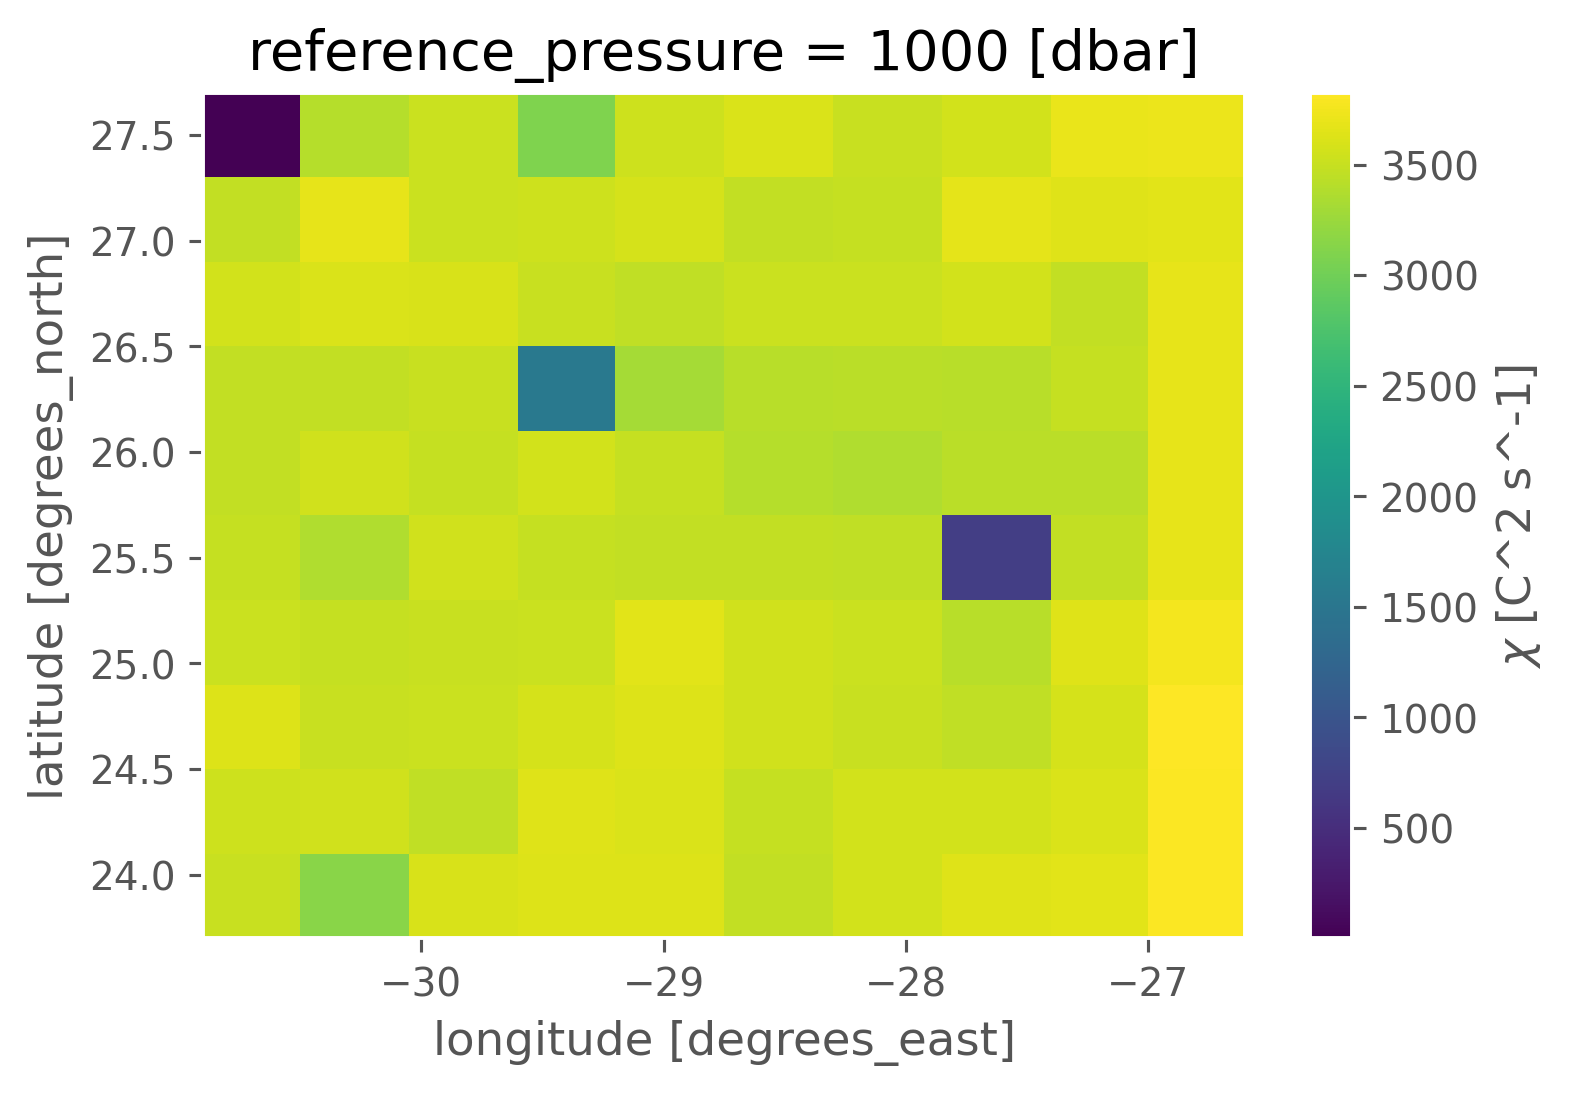

In [7]:
natre.chi.cf.sel(Z=slice(2000)).cf.count("Z").plot()

## Comparing latitudinal lines and  longitudinal lines

Interestingly, most "lines" do show eddy stirring : ~ 6/10 panels in the following figure.

So it does seem like a single CTD-χpod section has some chance of replicating that result.

In [9]:
def compute_single_line(section):
    return ed.sections.bin_average_vertical(
        section.cf.stack({"cast": ("latitude", "longitude")}).drop("cast"),
        "neutral_density",
        bins,
    )


lonlines = natre.groupby("longitude", squeeze=False).map(compute_single_line)
latlines = natre.groupby("latitude", squeeze=False).map(compute_single_line)

latlines.to_netcdf("../datasets/natre-along-lat-lines.nc")
lonlines.to_netcdf("../datasets/natre-along-lon-lines.nc")

In [104]:
latlines = xr.load_dataset("../datasets/natre-along-lat-lines.nc")
lonlines = xr.load_dataset("../datasets/natre-along-lon-lines.nc")

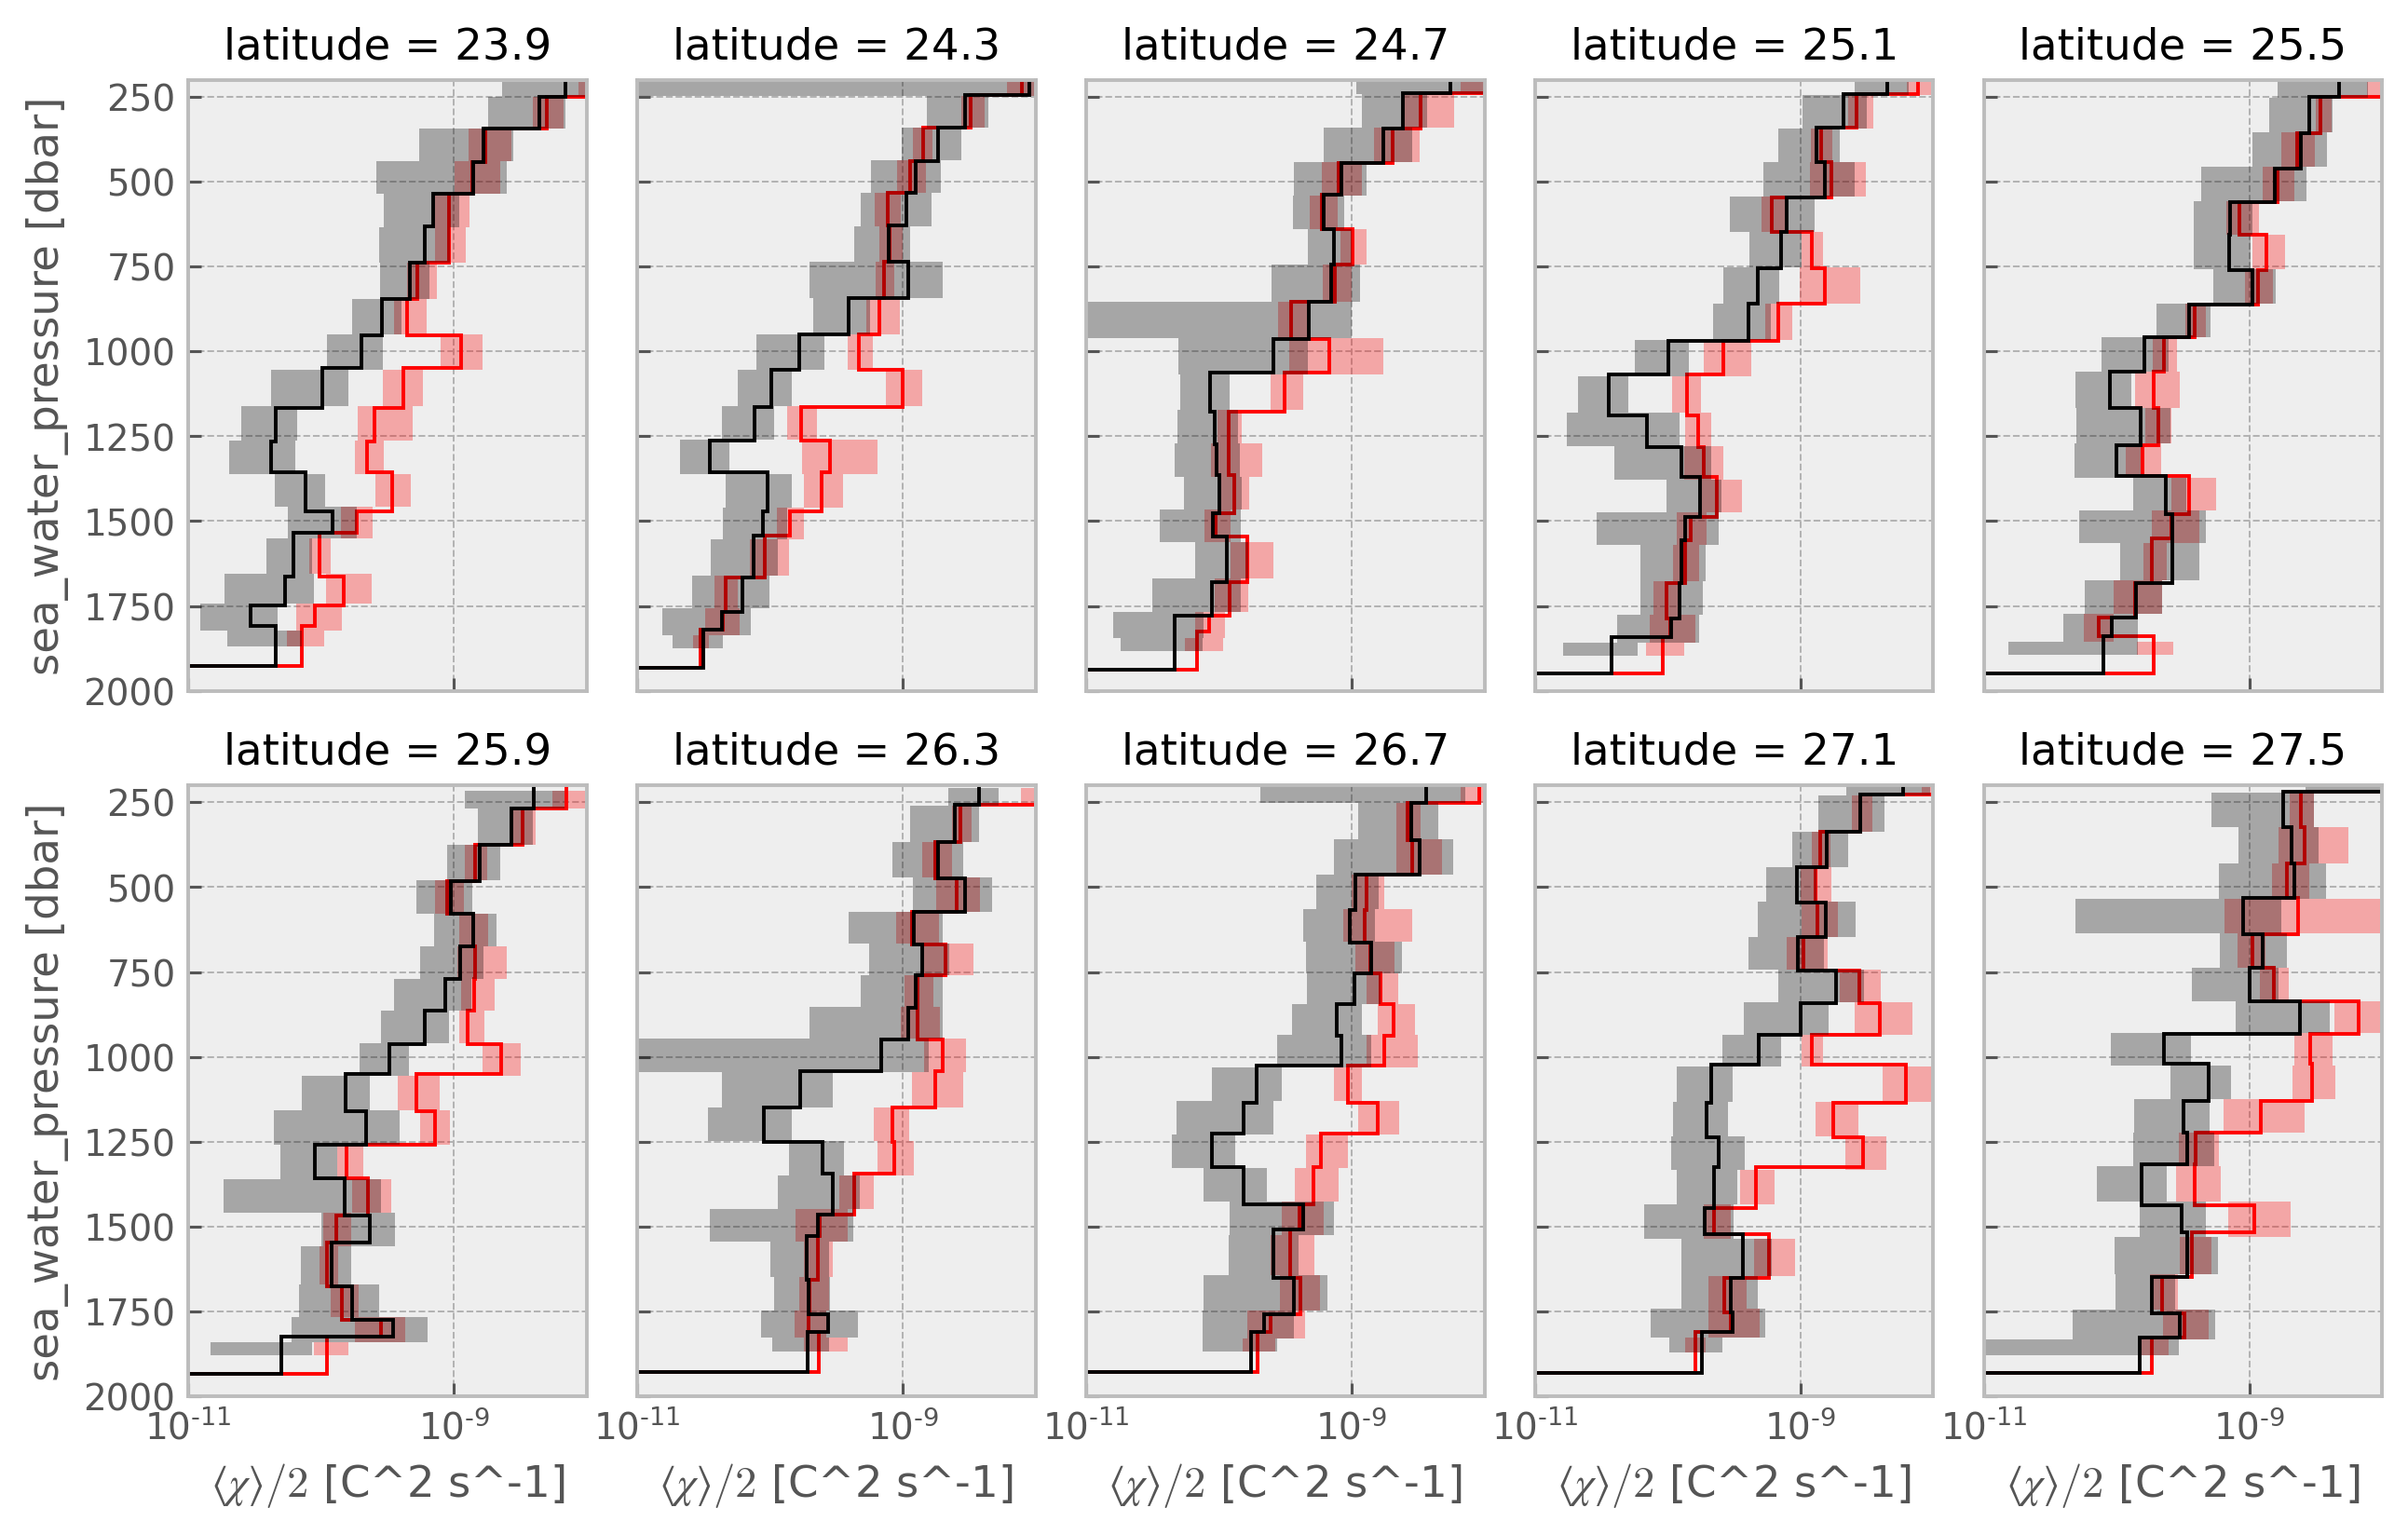

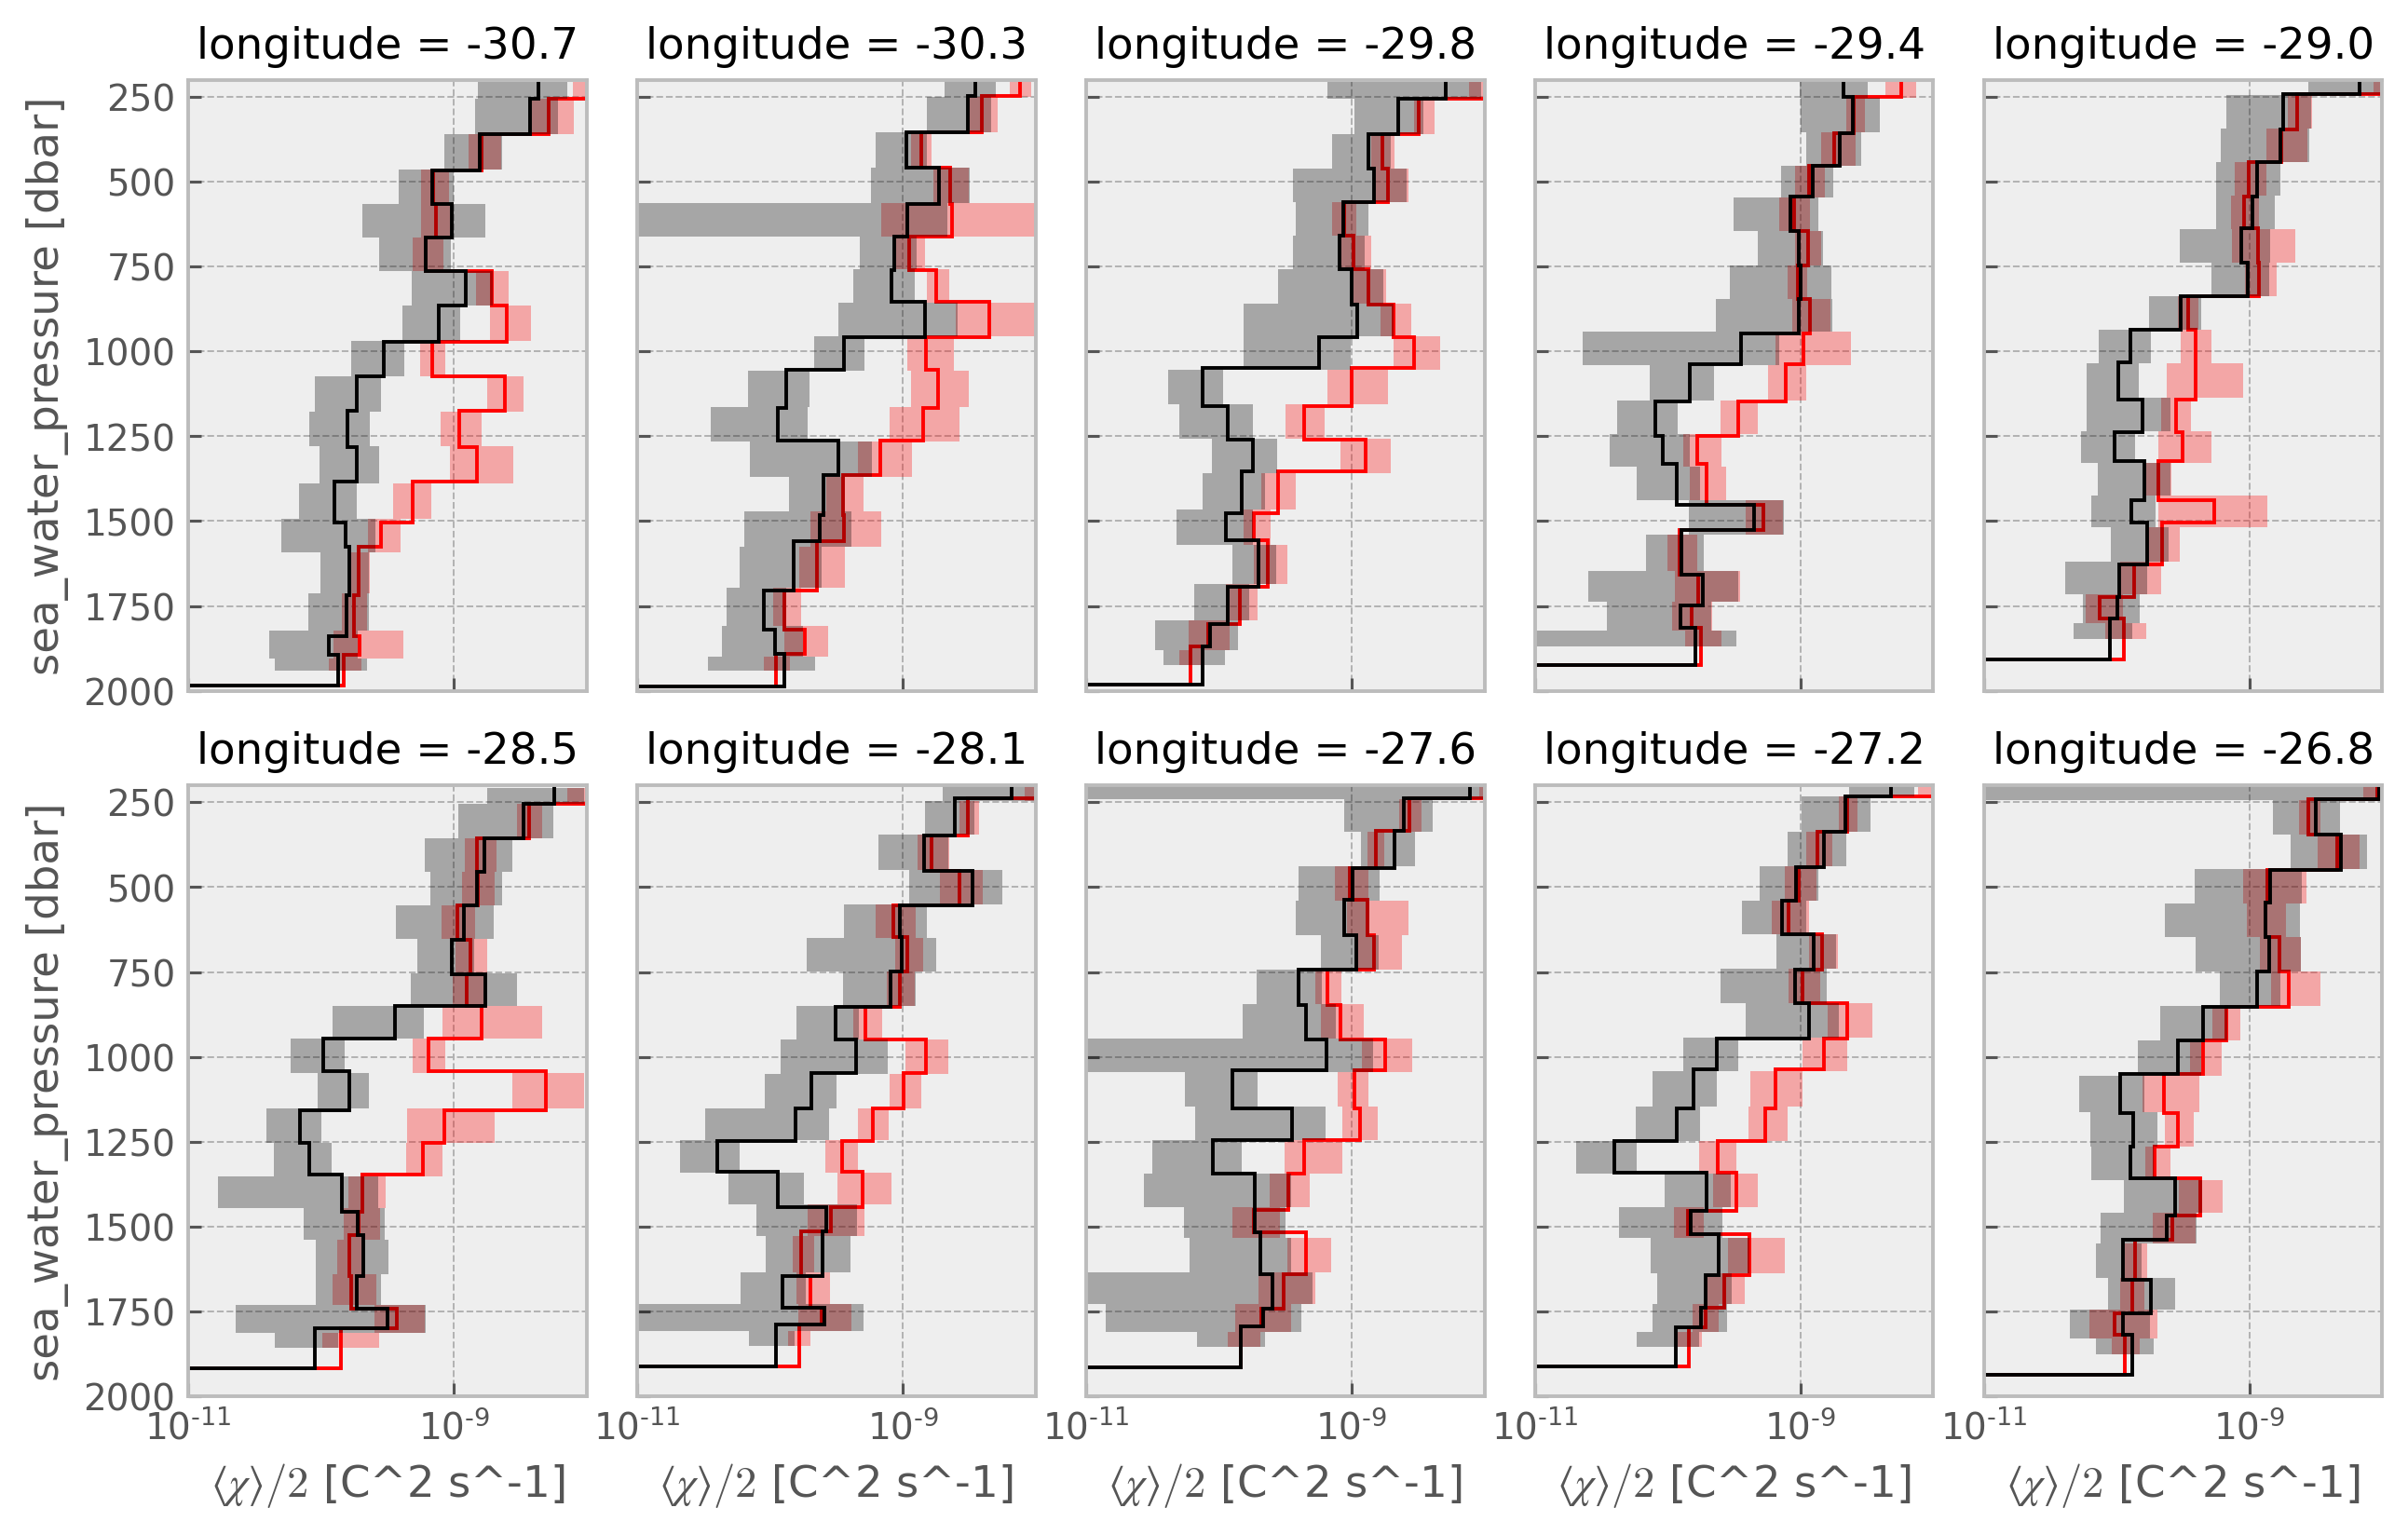

In [105]:
def plot_terms(ds, *, ax, x, y, color, **kwargs):
    dcpy.plots.fill_between_bounds(ds, x, color=color, y=y, ax=ax)


def plot_lines(ds, col):
    fg = xr.plot.FacetGrid(
        ds,
        col=col,
        col_wrap=5,
        aspect=1 / 1.8,
    )
    fg.map_dataset(plot_terms, x="chib2", hue=None, y="pres", color="r")
    fg.map_dataset(plot_terms, x="KρTz2", hue=None, y="pres", color="k")
    ax = fg.axes[0, 0]
    ax.set_ylim((2000, 200))
    ax.set_xlim(1e-11, 1e-8)
    ax.set_xscale("log")
    
plot_lines(latlines, col="latitude")
plot_lines(lonlines, col="longitude")

## Number of observations


Looks like the ctd-χpod section is on par with the NATRE section. Hopefully we don't lose too much on cleanup

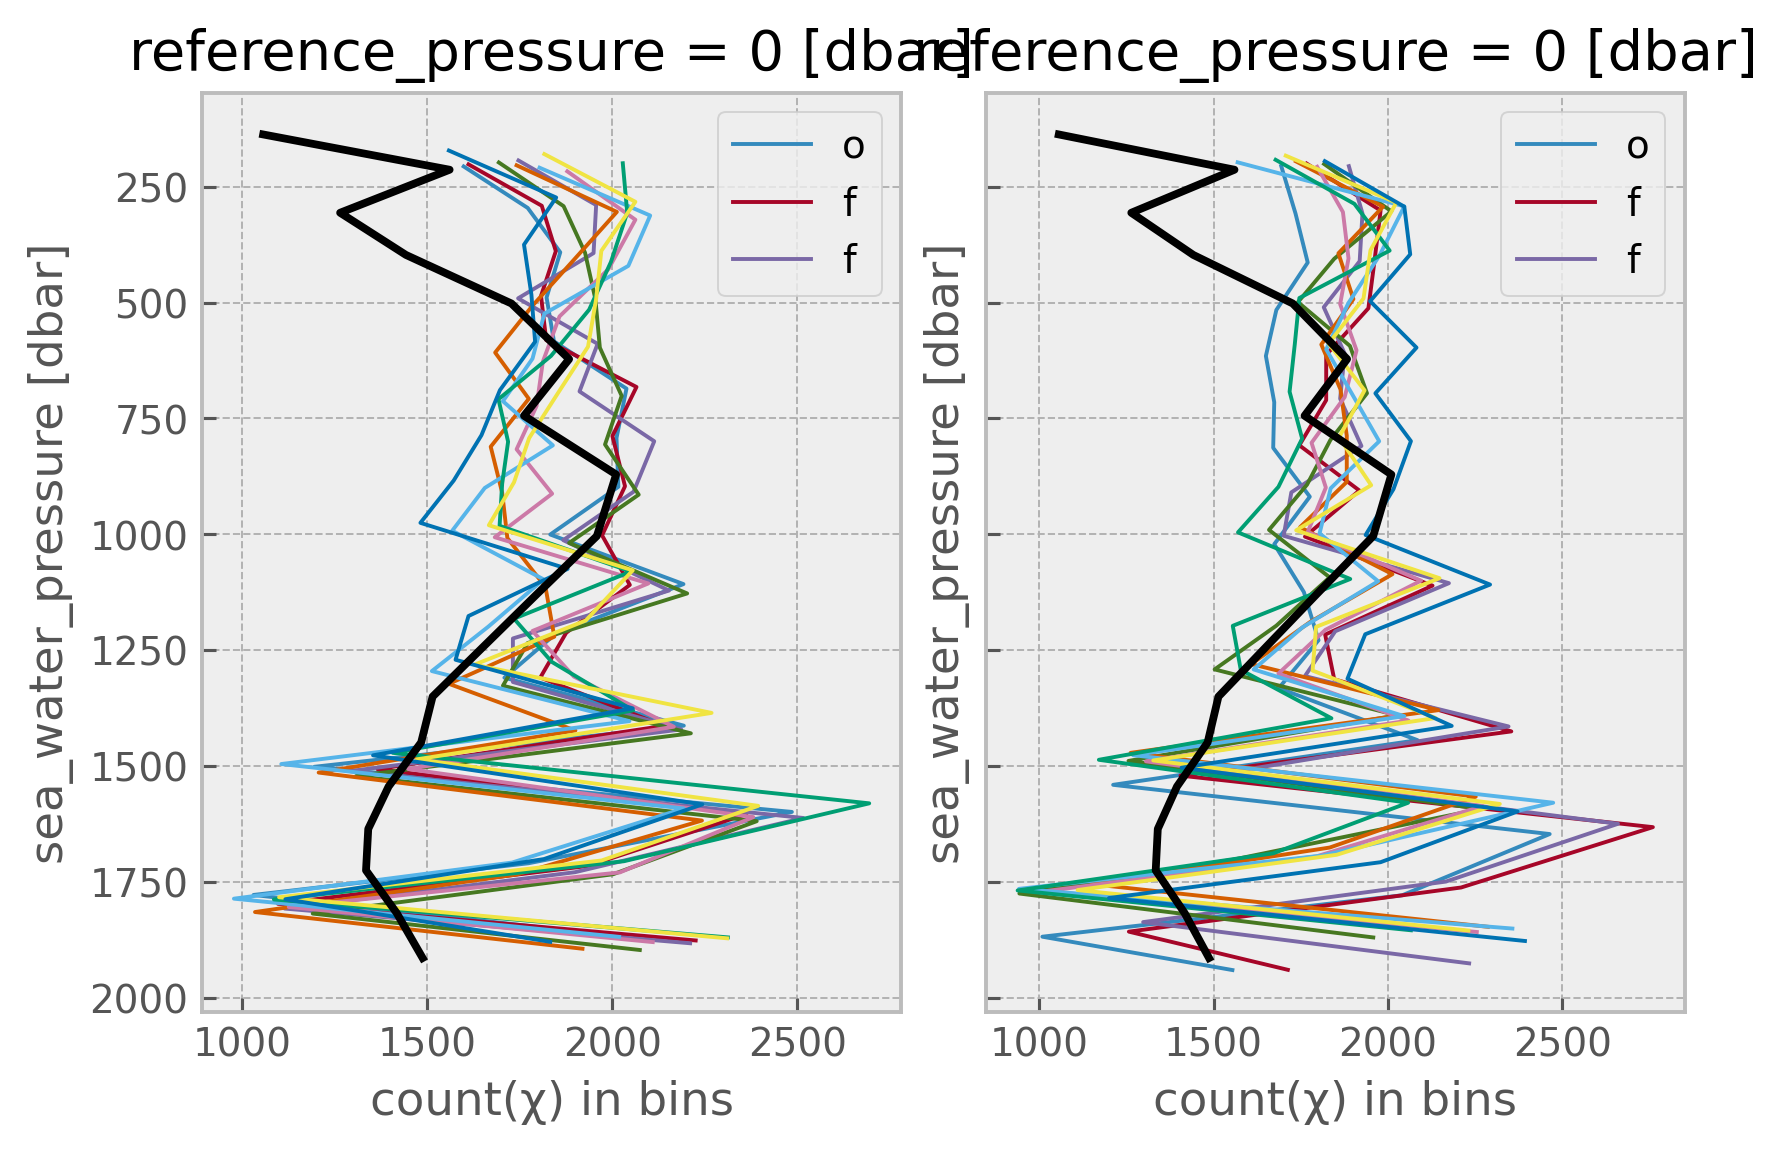

/Users/dcherian/mambaforge/envs/eddydiff/lib/python3.9/site-packages/bokeh/document/events.py:400: RuntimeWarning: deallocating CachingFileManager(<class 'netCDF4._netCDF4.Dataset'>, '/Users/dcherian/work/eddydiff/datasets/natre_large_scale.nc', mode='r', kwargs={'clobber': True, 'diskless': False, 'persist': False, 'format': 'NETCDF4'}), but file is not already closed. This may indicate a bug.
  super().dispatch(receiver)


In [130]:
f, ax = plt.subplots(1, 2, sharey=True, constrained_layout=True)
latlines.num_obs.cf.plot(hue="latitude", y="pres", ax=ax[0], lw=1)
lonlines.num_obs.cf.plot(hue="longitude", y="pres", ax=ax[1], lw=1);
for axx in ax:
    a05.num_obs.cf.plot(y="pres", ax=axx, color='k')
ax[0].legend("off")
ax[1].legend("off")